In [16]:
import numpy as np
from matplotlib import pyplot as plt
from helpers import *
%matplotlib inline

# Example: Poisson Problem with homog. Dirichlet BC's:
$u''(x) = b(x)$ on $x\in(0,1)$

$u(0)=u(1)=0$

## 1-dimensional grid

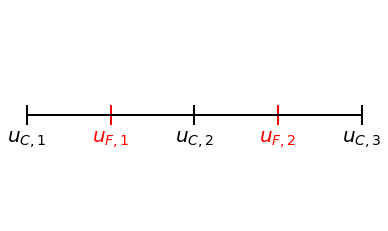

In [17]:
fig = plt.figure(facecolor='white')
ax = plt.axes()
ax.set_yticks([])
ax.set_xticks([0,2,4])
ax.set_xticklabels(["$u_{C,1}$","$u_{C,2}$","$u_{C,3}$"])
ax.set_xticks([1,3], minor=True)
ax.set_xticklabels(["$u_{F,1}$", "$u_{F,2}$"], minor=True)
ax.tick_params(length=20, width=2, direction='inout', labelsize='20', which='both')
ax.tick_params(colors='r', which="minor")
ax.set_ylim(ymin=-.2, ymax=.2)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_linewidth(2)
ax.get_xaxis().set_visible(True)

## Discretization

Finite difference discretization yields the system
\begin{alignat*}{3}
    &\begin{bmatrix}
        2& -1& & & \\
        -1& 2& -1& & \\
        & -1& 2& -1& \\
        & & -1& 2& -1\\
        & & & -1& 2
    \end{bmatrix}
    &&\begin{bmatrix}
        u_{C, 1}\\
        {\color{red} u_{F,1}}\\
        u_{C, 2}\\
        {\color{red} u_{F,2}}\\
        u_{C, 3}
    \end{bmatrix}
    &=
    &\begin{bmatrix}
        b_{C, 1}\\
        {\color{red} b_{F,1}}\\
        b_{C, 2}\\
        {\color{red} b_{F,2}}\\
        b_{C, 3}
    \end{bmatrix}
    \\
    &\hspace{2cm} A &&\qquad u &= &\qquad b
\end{alignat*}

In [18]:
n_c = 3
n = 2*n_c - 1
a = 2.0 * np.eye(n) - np.diag(np.ones(n-1), 1) - np.diag(np.ones(n-1),-1)
a

array([[ 2., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.],
       [ 0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1.,  2.]])

## Prolongation/Interpolation
$$
P =
\begin{bmatrix}
    1 & &\\
    1/2 & 1/2 &\\
    & 1 & \\
    & 1/2 & 1/2\\
    & & 1
\end{bmatrix}
$$

In [19]:
p = get_interpolation_matrix(n_c-1)
p

array([[1. , 0. , 0. ],
       [0.5, 0.5, 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ]])

## Pre- and Post-Smoothing: Gauss-Seidel
$$
M = \begin{bmatrix}
   2 &   &   &   &   \\ 
    -1& 2  &   &   &   \\ 
  &   -1  & 2  &   &   \\ 
   & &  -1   & 2  &   \\ 
    &  &   &  -1 & 2  \\ 
\end{bmatrix}
$$

In [20]:
m = np.tril(a)
m

array([[ 2.,  0.,  0.,  0.,  0.],
       [-1.,  2.,  0.,  0.,  0.],
       [ 0., -1.,  2.,  0.,  0.],
       [ 0.,  0., -1.,  2.,  0.],
       [ 0.,  0.,  0., -1.,  2.]])

## V-Cycle

\begin{align*}
    T           &= (I-M^{-T}A)(I-PA_c^{-1}P^TA)(I-M^{-1}A)\\    
    I-X^{-1}A   &= (I-M^{-T}A)(I-M^{-1}A)\\
    X           &= M(M + M^{T} - A)^{-1} M^T = \frac{1}{2}MM^T \\
\end{align*}


In [21]:
I = np.eye(n)
a_c   = p.transpose() @ a @ p
t = (I - np.linalg.inv(m.transpose()) @ a) @ (I - p @ np.linalg.inv(a_c) @ p.transpose() @ a) @ (I - np.linalg.inv(m) @ a)
max(np.linalg.eigvals(t))

0.18911684020580705

In [22]:
def multigrid_step(a, x, b):
  n_c   = len(b) // 2
  p     = get_interpolation_matrix(n_c)
  a_c   = p.transpose() @ a @ p
  
  x     = gauss_seidel_forward(a, x, b)
  
  res   = b - a @ x
  res_c = p.transpose() @ res
  err_c = np.linalg.solve(a_c, res_c)
  x     = x + p @ err_c

  x     = gauss_seidel_backward(a, x, b)

  return x

## Numerical Example

In [23]:
x0 = np.random.randn(n)
b = a @ x0

In [24]:
x         = np.zeros_like(x0)

it_steps  = 10
errs      = []

for i in range(it_steps):
  x = multigrid_step(a, x, b)
  errs.append(np.linalg.norm(x - x0))

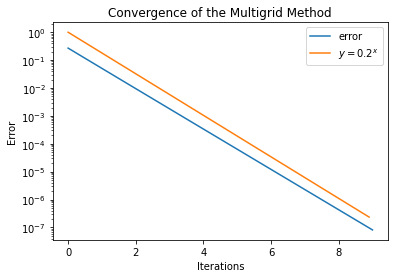

In [25]:
plt.semilogy(np.arange(it_steps), errs, label="error")
plt.semilogy(np.arange(0, it_steps-1, 0.1), 0.18**np.arange(0, it_steps-1, 0.1), label="$y=0.2^x$")
fig = plt.gcf()
ax = plt.gca()
ax.set_xlabel("Iterations")
ax.set_ylabel("Error")
ax.set_title("Convergence of the Multigrid Method")
ax.legend()

## Analysis

\begin{align*}
    \tilde{X}   &= \mathrm{diag}(A) = 2I\\
    \lambda(\tilde{X}^{-1}X) &= \frac{1}{4}\lambda_{\max}(MM^T)\\
    MM^T        &=
    \begin{bmatrix}
        4& -2& & &\\
        -2& 5& -2& &\\
        & -2& 5& -2&\\
        & & -2& 5&-2\\
        & & & -2&5
    \end{bmatrix}
\end{align*}

By the Geshgorin circle theorem $\lambda_{\max}(\tilde{X}^{-1}X) \leq 9/4 = 2.25$.

Use the left inverse

$$
\tilde R = 
\begin{bmatrix}
1 &0 &0 &0 &0\\
0 &0 &1 &0 &0\\
0 &0 &0 &0 &1
\end{bmatrix}
$$

to estimate $K_{\tilde X}$:

\begin{align*}
K_{\tilde X}    &\leq \max_{v\in\mathbf{R}^n\setminus \{0\}}\frac{\|(I-P\tilde R)v\|_{\tilde X}^2}{\|v\|_A^2}\\
                &= \max_{v\in\mathbf{R}^n\setminus \{0\}}\frac{1}{1+\frac{C}{D}}\\
                &= 1
\end{align*}

where

$$ 
C = \left(\frac{v_{C,1}+v_{C,2}}{2}\right)^2 + \left(\frac{v_{C,2}+v_{C,3}}{2}\right)^2 + \left(\frac{v_{C,1}}{2}\right)^2 + \left(\frac{v_{C,3}}{2}\right)^2
$$

and

$$ 
\left(v_{F,1}-\frac{v_{C,1}+v_{C,2}}{2}\right)^2+\left(v_{F,2}-\frac{v_{C,2}+v_{C,3}}{2}\right)^2 
$$

In [36]:
r = np.array([[1,0,0,0,0],[0,0,1,0,0],[0,0,0,0,1]])
I-p@r

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  1. , -0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  1. , -0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]])

Therefore, $K_X \leq \lambda_{\max}(\tilde{X}^{-1}X) K_{\tilde X} \leq 2.25$.

$\rho(T) = 1 - \frac{1}{K_X} \leq 1-\frac{1}{2.25}\approx 0.56$

In [26]:
errs[-1]

8.155194912017161e-08

In [27]:
np.linalg.norm(t**it_steps @ x0)

7.012975152383332e-08